**Project Overview**

This project develops machine learning models (Logistic Regression, Decision Tree, and LightGBM) to predict earthquake damage levels in buildings affected by the 2015 earthquakes in Kavrepalanchok, Nepal. 

Using building characteristics and structural features, the models classify damage into three categories: low damage (Grade 1), medium damage (Grade 2), and near-complete destruction (Grade 3).

**Potential Real-World Impact**

Earthquake damage prediction models serve critical functions in disaster management and urban planning :

- Disaster Preparedness: Enable rapid damage assessment for emergency response allocation
- Risk Assessment: Identify vulnerable building types for preventive interventions
- Insurance Applications: Support actuarial modeling for earthquake insurance policies
- Urban Planning: Guide building code improvements and construction standards
- Reconstruction Planning: Prioritize rebuilding efforts based on predicted damage patterns



# 010: Prepare 

Steps: 
1. Import libraries
2. Load dataset
3. Data quality assessment - to note xtics and structure of the dataframe
4. Data Cleaning 

**1. Import Libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# set styles
sns.set_style("whitegrid")  # or "darkgrid", "white", "ticks", "dark"
sns.set_palette("pastel")   # or try "husl", "rocket", "mako", "coolwarm", etc.



from category_encoders import OneHotEncoder 
from category_encoders import OrdinalEncoder 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


**2. Load Dataset**

In [2]:
df = pd.read_csv("/workspaces/Earthquake-Damage-Classification-Kavrepalanchok-Nepal/data/kavrepalanchok_raw.csv")

# df.head()
df.info()
                 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76533 entries, 0 to 76532
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   b_id                    76533 non-null  int64 
 1   building_id             76533 non-null  int64 
 2   count_floors_pre_eq     76533 non-null  int64 
 3   count_floors_post_eq    76533 non-null  int64 
 4   age_building            76533 non-null  int64 
 5   plinth_area_sq_ft       76533 non-null  int64 
 6   height_ft_pre_eq        76533 non-null  int64 
 7   height_ft_post_eq       76533 non-null  int64 
 8   land_surface_condition  76533 non-null  object
 9   foundation_type         76533 non-null  object
 10  roof_type               76533 non-null  object
 11  ground_floor_type       76533 non-null  object
 12  other_floor_type        76533 non-null  object
 13  position                76533 non-null  object
 14  plan_configuration      76533 non-null  object
 15  co

**3. Data Quality Assessment**

In [ ]:
# df.head()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Examine categorical variables
uniq_val_col = df.columns
for col in uniq_val_col:
    print(f"\n{col} unique values: {df[col].nunique()}")
    print(df[col].value_counts().head())


Missing values per column:
b_id                      0
building_id               0
count_floors_pre_eq       0
count_floors_post_eq      0
age_building              0
plinth_area_sq_ft         0
height_ft_pre_eq          0
height_ft_post_eq         0
land_surface_condition    0
foundation_type           0
roof_type                 0
ground_floor_type         0
other_floor_type          0
position                  0
plan_configuration        0
condition_post_eq         0
superstructure            0
damage_grade              0
dtype: int64

b_id unique values: 76533
b_id
87473    1
87479    1
87482    1
87491    1
87496    1
Name: count, dtype: int64

building_id unique values: 76533
building_id
87473    1
87479    1
87482    1
87491    1
87496    1
Name: count, dtype: int64

count_floors_pre_eq unique values: 9
count_floors_pre_eq
2    50298
3    16783
1     6767
4     2004
5      590
Name: count, dtype: int64

count_floors_post_eq unique values: 9
count_floors_post_eq
2    33998
0    1

Key characteristics to note about our dataframe, df: 
1. Our target variable (`damage_grade` column) has 5 unique values, Grade 1,2,3,4,5. 
2. Also, our goal is to differentite these five Grades by getting entries with `severe_damage` above 3 and those below as separate data points. 
4. We have post earthquake data (ending in "...post_eq"). These are leaky columns - to be dropped when cleaning.
5. `building_id` is the key column, rep. all the Nepal buildings damaged in 2015 during earthquakes. Since we don't need the exact number of each building, we will turn this column into the index for easier readability and lookup. Also `b_id` is same as `building_id` so we will drop it. 

**4. Data Cleaning**

Steps: 
- make `building_id` as index and drop `b_id`
- drop leaky columns
- create our binary target `severe_damage` column - with two values 1 or 0 for each building, where buildings with `damage_grade` greater than 3 are encoded at 1 while all other buildings are endoded at 0.
- Correlation Matrix (heatmap) - to find columns with strong correlation with `severe_damage`  correlation and drop then to avoid redundant columns offering same classification power i.e. Reduce complexity and increaseefficiency.


In [ ]:
# make building_id as index 
        # df_clean = df.drop(columns="building_id", inplace=True)  # allows for df.loc[index] 

df_clean = df.set_index("building_id", drop=True)   # allows df.loc[building_id],more convinient than df.loc[index]

# drop "b_id"
df_clean = df_clean.drop(columns = "b_id")


df_clean.head()

In [ ]:
# Drop leaky columns - leaky columns are columns that have post-earthquake data, i.e. any column ending in '..._post_eq'
#                      the goal is to predict earthquake damage, having columns with already recorded post_eq data is 
#                      basically cheating. 

            # drop_cols = []
            
            # for col in df_clean.columns: 
            #     if "post_eq" in col: 
            #         drop_cols.append(col)
            
            # drop_cols 

# Make simple into a list comprehension (Pythonic way of expressing the same logic in a single expression) 

drop_cols = [col for col in df_clean.columns if "post_eq" in col]

df_clean.drop(columns=drop_cols, inplace=True)

# df_clean.info()



In [ ]:
# create our binary target `severe_damage` column 

df_clean["damage_grade"] = df_clean["damage_grade"].str[-1].astype(int)   #grabs last character i.e. 1,2,3,4,5 leaving Grade
df_clean["severe_damage"] = (df_clean["damage_grade"] > 3).astype(int)     # if 4 or 5, encode as 1s, else as 0s

# Then drop the redundant 'damage_grade'

df_clean = df_clean.drop(columns="damage_grade")

# df_clean.info()

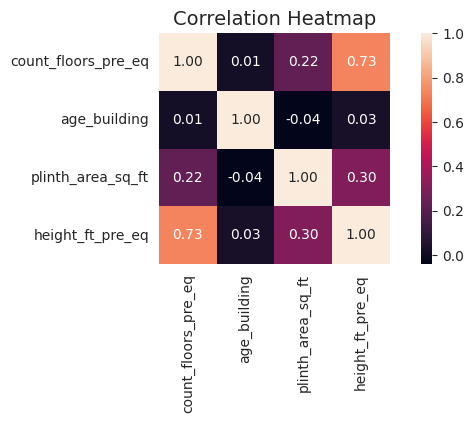

In [ ]:
# Correlation Matrix (heatmap) - to find columns with strong correlation with severe_damage

# Select only the relevant columns
correlation = df[["count_floors_pre_eq", "age_building", "plinth_area_sq_ft", "height_ft_pre_eq"]].corr()

# Plot correlation matrix as a heatmap with values 
plt.figure(figsize=(8,3))
sns.heatmap(
    correlation,
    annot=True,        # put the correlation values inside cells
    fmt=".2f",         # format as float with 2 decimal places
    cmap="rocket",   # nice diverging colormap
    cbar=True,         # show the color bar
    square=True        # make cells square
)
plt.title("Correlation Heatmap", fontsize=14)
plt.show() 

In [ ]:
# We can see that `count_floors_pre_eq` is strongly correlated with `height_ft_pre_eq`. They both offer similar or ar 
# least close enough predictive power. Keeing the two is redundant. We fix this by dropping `count_floors_pre_sq`. 

# We keep `height_ft_pre_eq` because its values are continuous (a wide range of independent heights) while 
#`count_floors_pre_eq` is discrete (values=[1, 0, 2, 3, 4, 9, 5, 6, 8, 7]) and loses some detail if used in classification

df_clean.drop(columns="count_floors_pre_eq", inplace=True)


df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76533 entries, 87473 to 163998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            76533 non-null  int64 
 1   plinth_area_sq_ft       76533 non-null  int64 
 2   height_ft_pre_eq        76533 non-null  int64 
 3   land_surface_condition  76533 non-null  object
 4   foundation_type         76533 non-null  object
 5   roof_type               76533 non-null  object
 6   ground_floor_type       76533 non-null  object
 7   other_floor_type        76533 non-null  object
 8   position                76533 non-null  object
 9   plan_configuration      76533 non-null  object
 10  superstructure          76533 non-null  object
 11  severe_damage           76533 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 7.6+ MB


# 020: Explore 

Steps:

1. Bar Chart - show class balance (1s vs 0s) of `severe_damage` to see the frequency distribution of severe damage (1) and less severe damage (0) buildings
2. Bar Chart - are buildings with certain roof types more likely to suffer severe damage
3. Box Plots - is there relationship between `severe_damage` wrt to `height_ft_pre_eq` , `age_building`, or `plinth_area_sq_rt`

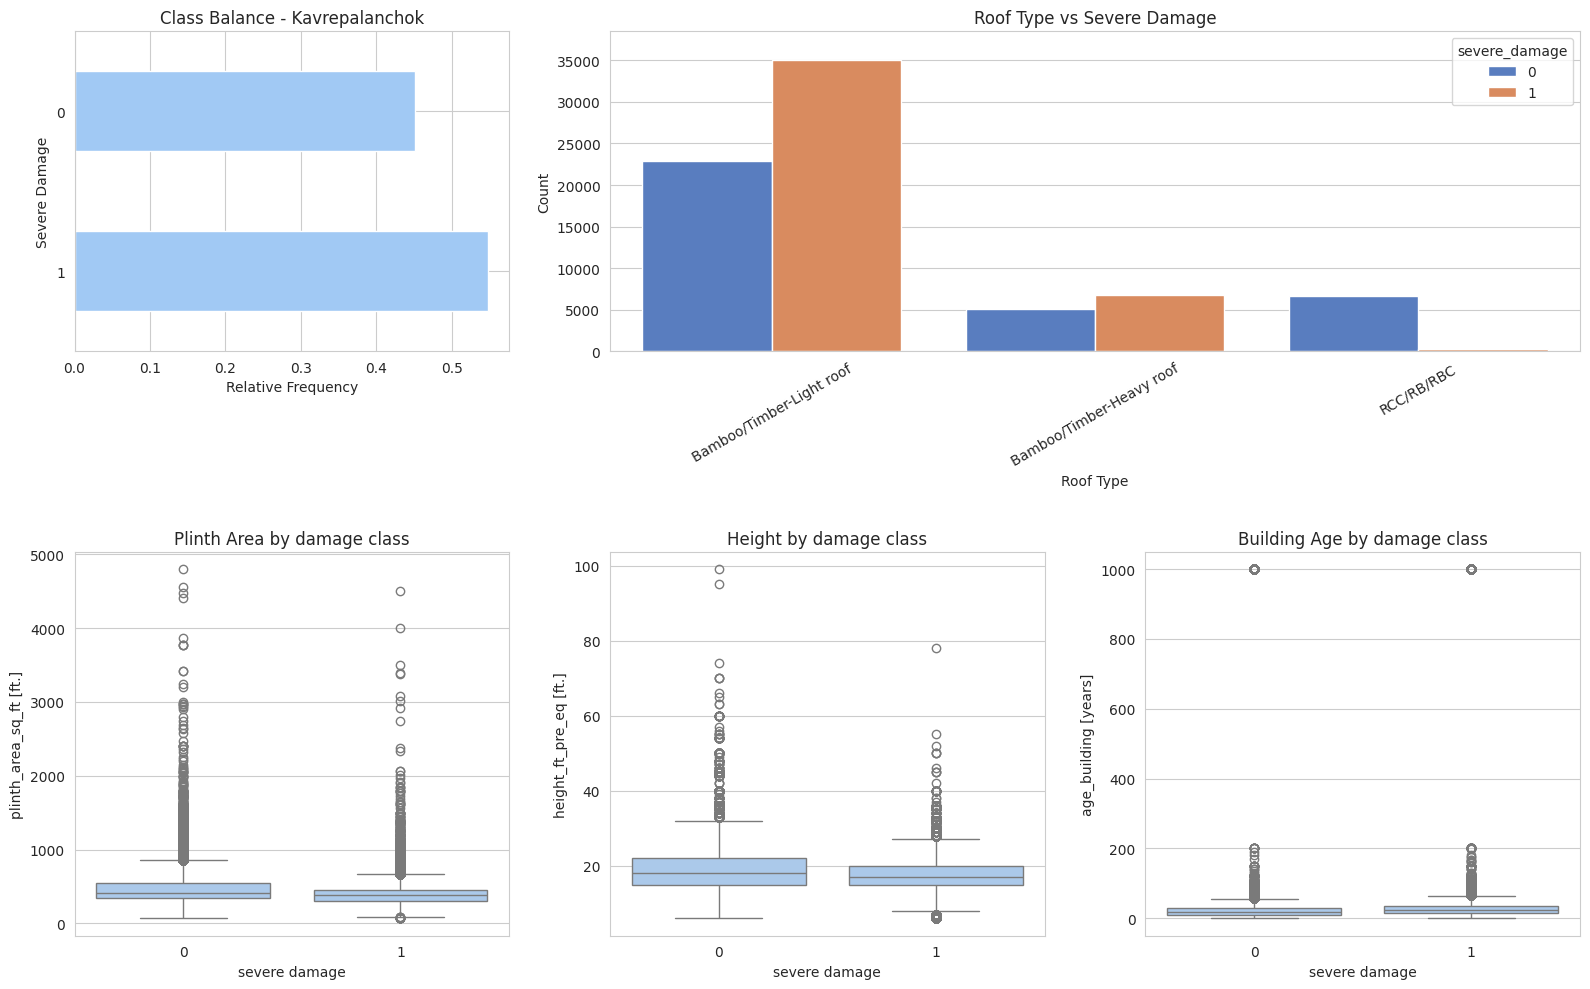

In [ ]:
# Step 1 - 3 all in one 


fig = plt.figure(figsize=(16, 10))

gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.2])  # 2 rows, 3 col, second row a bit taller

# 1. Bar Chart - severe_damage class balance 

ax1 = fig.add_subplot(gs[0, 0])
df_clean["severe_damage"].value_counts(normalize=True).plot(
    kind="barh", ax=ax1
)
ax1.set_ylabel("Severe Damage")
ax1.set_xlabel("Relative Frequency")
ax1.set_title("Class Balance - Kavrepalanchok")

# 2. Bar Chart - Roof Type vs Severe Damage (span 2 cols on right)

ax2 = fig.add_subplot(gs[0, 1:])
sns.countplot(data=df_clean, x="roof_type", hue="severe_damage", palette="muted", ax=ax2)
ax2.set_title("Roof Type vs Severe Damage")
ax2.set_ylabel("Count")
ax2.set_xlabel("Roof Type")
ax2.tick_params(axis="x", rotation=30)  # less steep rotation
ax2.margins(y=0.1)  # add breathing room

# 3. Box Plots -rlship between severe_damage wrt to plinth_area_sq_ft, height_ft_pre_eq, age_building

ax3 = fig.add_subplot(gs[1, 0])
sns.boxplot(x="severe_damage", y="plinth_area_sq_ft", data=df_clean, ax=ax3)
ax3.set(xlabel="severe damage", ylabel="plinth_area_sq_ft [ft.]",
        title="Plinth Area by damage class")

ax4 = fig.add_subplot(gs[1, 1])
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df_clean, ax=ax4)
ax4.set(xlabel="severe damage", ylabel="height_ft_pre_eq [ft.]",
        title="Height by damage class")

ax5 = fig.add_subplot(gs[1, 2])
sns.boxplot(x="severe_damage", y="age_building", data=df_clean, ax=ax5)
ax5.set(xlabel="severe damage", ylabel="age_building [years]",
        title="Building Age by damage class")

# Adjust layout
plt.tight_layout(h_pad=3, w_pad=2)  # extra breathing room
plt.show()


# 030: Build 

Steps: 
1. Split - create feature matrix X and target vector y ("severe_damage")
2. Divide dataset into training and validation sets using randomized split (80-20 split)
3. Calculate baseline accuracy score for our models
4. Create a Logistic Regression model that uses logistic regression algorithm to predict building damage:
    
    - Iterate
    - Calculate training and validation accuracy scores of the `model_lr`
    - Create a better `tuned_lr` with better parameters from GridSearchCV 
    - Calculate performance metrics of `tuned_lr`
  
5. Create a Decicion Tree Model (`model_dt`) that uses decision tree algorithms to  predict building damage:
    
    - Iterate - using a range of hyperparameters from for `max_depth` and a for loop
    - Calculate training and validation accuracy scores of the `model_dt`
    - Plot validation curve of `model_dt` using the above scores to help locate the best `max_depth` hyperparameter
    - Use the best `max_depth` to create the final Decision Tree model `final_model_dt`
    - Evaluate - use `final_model_dt` to geneate a list of test predictions on unseen external test data `X_test`

6. Create better models because in this case, the Logistic Regression and Decision Tree are converging to the same general model complexity (Validation accuracy ~0.66, training accuracy ~0.68). This shows that the dataset has limited signal for decision trees alone — you’ve hit the ceiling for a single tree.

- For earthquake damage prediction, ensembles (Random Forests, Gradient Boosting, XGBoost/LightGBM) usually lift performance well beyond that 0.66 ceiling, because they combine many weak trees into a stronger predictor.

In [ ]:
# Split df_clean into feature matrix `X` and target vector `y` 

target = "severe_damage"
X = df_clean.drop(columns = target)
y = df_clean[target]
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (76533, 11)
y shape: (76533,)


In [ ]:
# Using X and y, we divide them into training and validation sets using a randomized split. 
# Validation set should be 20% of the total data.

X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size = 0.2, random_state = 42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


In [ ]:
# Baseline - calculating baseline accuracy score for our models 

acc_baseline = y_train.value_counts(normalize = True)[1]
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


## 031: Logistic Regression Model 


Steps: 
- Define the parameter grid with a range of hyperparameters 
- Create the Logistic Regression model pipeline 
- Use GridSearchCV to incorporate the hyperparamaters into the model pipeline and cross-validate wrt to 'recall' scoring
- Train the model on the training data to find the best Logistic Regression model, best parameters, and cross validation results of all trained models 
- Extract the best trained model and use it to get predictions on training data and validation data 
- Print the performance metrics and classification report for evaluation 

In [ ]:
# Logistic regression hyperparameter tuning with GridSearch 

# Define the parameter grid for hyperparameter tuning: 
#     C-strength of regularization, penalty-regularization type, solver-algorithm with needed math for optimization

lr_param_grid = {
    "logisticregression__C": [0.01, 0.1, 1, 10],
    "logisticregression__penalty": ["l1", "l2"],
    "logisticregression__solver": ["liblinear"]  
}

# lr_model - the pipeline of the model, not the  trained model yet

lr_model = make_pipeline(                                        
    OneHotEncoder(use_cat_names=True),                           # turns categorical variables into numeric 0/1 (ML models can’t handle text directly)
    LogisticRegression(max_iter=2000, random_state=42)           # LogisticRegression-the algorithm (classifier-an algorithm that outputs classes instead of continuous values)
)

# GridSearchCV tries every combo in param_grid i.e. 4 values of C × 2 penalties × 1 solver = 8 experiments 
# lr_grid is the variable storing the GridSearchCV object (containing lr_model pipeline, params, and cv settings)

lr_grid = GridSearchCV(                                           
    lr_model,
    lr_param_grid,
    cv=5,
    scoring="recall",                                            
    n_jobs=-1
)

# Below code uses lr_grid to fit every combo onto training data. Evaluates the combos, keeps the results, and stores the best model. 
# It holds the GridSearchCV object after training (containing best model, best params, and cv results of every model combo tried
#                                                           - all accessble via .best_estimator_, .best_params_, .cv_results_) 


lr_grid.fit(X_train, y_train)                                      

print("\n=== Logistic Regression ===")
print("Best Params:", lr_grid.best_params_)   


# best_lr - is the trained model we are looking for, accessed from lr_grid by .best_estimator_

best_lr = lr_grid.best_estimator_                                   


# Making predictions with the best_lr model on both training and validation sets

lr_y_train_preds = best_lr.predict(X_train)  
lr_y_val_preds = best_lr.predict(X_val) 

# Performance Metrics - take the above predictions and compare them to the true values y_train and y_val
#      If both scores are close, the model generalizes well. But, if training scores are much higher, then it is overfitting.

print("\n=== Training Set Metrics (Positive Class = severe_damage = 1)===")
print(f"Accuracy: {accuracy_score(y_train, lr_y_train_preds):.4f}")
print(f"Recall:   {recall_score(y_train, lr_y_train_preds):.4f}")
print(f"Precision:{precision_score(y_train, lr_y_train_preds):.4f}")
print(f"F1:       {f1_score(y_train, lr_y_train_preds):.4f}")

print("\n=== Validation Set Metrics (Positive Class = severe_damage = 1) ===")
print(f"Accuracy: {accuracy_score(y_val, lr_y_val_preds):.4f}")
print(f"Recall:   {recall_score(y_val, lr_y_val_preds):.4f}")
print(f"Precision:{precision_score(y_val, lr_y_val_preds):.4f}")
print(f"F1:       {f1_score(y_val, lr_y_val_preds):.4f}")

# Validation metrics - this is what matters: how well the model performs on unseen data.

print("Classification Report from Validation Set (X_val, y_val):")
print(classification_report(y_val, lr_y_val_preds, digits=4))



=== Logistic Regression ===
Best Params: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}

=== Training Set Metrics (Positive Class = severe_damage = 1)===
Accuracy: 0.6516
Recall:   0.9355
Precision:0.6208
F1:       0.7463

=== Validation Set Metrics (Positive Class = severe_damage = 1) ===
Accuracy: 0.6530
Recall:   0.9342
Precision:0.6241
F1:       0.7483
Classification Report from Validation Set (X_val, y_val):
              precision    recall  f1-score   support

           0     0.7907    0.3063    0.4415      6856
           1     0.6241    0.9342    0.7483      8451

    accuracy                         0.6530     15307
   macro avg     0.7074    0.6203    0.5949     15307
weighted avg     0.6987    0.6530    0.6109     15307



**Explanations:**

I used `scoring="recall"` in GridSearchCV so that the search would pick parameters that maximized recall during cross-validation, not accuracy.

Recall - measures a model's ability to find all actual positive cases (`severe_damage` = 1), making it crucial for disaster preparedness, where failing to detect an event is more dangerous than an unnecessary alarm. In earthquake classification problems, Recall is the most important metric over precision, accuracy, and the F1 score because missing a real earthquake (a false negative) can have catastrophic consequences, outweighing the impact of false alarms (false positives). [More on classification metrics -> developers.google](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall#:~:text=The%20F1%20score%20is%20the,average%20of%20precision%20and%20recall.&text=This%20metric%20balances%20the%20importance,a%20perfect%20score%20of%201.0.)

All the metrics (recall, precision, F1) are being calculated with `severe_damage = 1` as the positive class / "True Positive" focus. For more details on 0, look at the classification report. 

**Conclusion**

- Recall = 0.9342 (very high): The model catches most of the severe_damage = 1 cases. i.e, it is tuned toward safety/recall. This is a great score as real-world scenarios require at least 0.90+. 
- Precision = 0.6241 (moderate): Out of all buildings predicted as “severely damaged,” only about 62% actually are. That means we have more false alarms than is necessary. The next goal is to increase this to about 0.70 - 0.90 to avoid drowning in false alarms. 
- Accuracy = 0.6530 (low): This is expected given that accuracy gets dragged down when the model prioritizes recall over precision. Anything between 0.65–0.80 is realistic if recall is prioritized.
- F1 = 0.7483 (good): This shows the model is decent at balancing recall and precision, but not perfect. F1 is the harmonic mean of precision and recall, therefore a healthy zone of 0.75–0.85 is great, showing the model is not sacrificing one metric completely for the other.

*Note the Class imbalance effect*: From the classification report, Class 0 (Grade 1 - 3) has poor recall (0.3063), while class 1 (Grade 4 - 5) has very high recall. This means that the model is heavily biased toward catching positives, almost at the expense of negatives. 

With this in mind, the conclusion is that this Logistic Regression model is highly effective at detecting severely damaged buildings (recall = 0.9342), making it useful in situations where false negatives are unacceptable. However, its overall accuracy (0.6530) and precision (0.6241) suggest many false positives, meaning the model is over-flagging damage. This trade-off is typical of models optimized for recall. To see if we can improve both accuracy and precision without sacrificing too much recall, it makes sense to try more flexible models like Decision Trees and LightGBM.


In [ ]:
# df_copy = df_clean.copy()
# # df_copy.info()

In [ ]:
# # Proper Data Prep for Classification 

# # List of categorical columns to encode
# categorical_columns = [
#     'land_surface_condition', 'foundation_type', 'roof_type',
#     'ground_floor_type', 'other_floor_type', 'position',
#     'plan_configuration', 'superstructure'
# ]

# label_encoders = {}
# for col in categorical_columns:
#     le = LabelEncoder()
#     df_copy[col + '_enc'] = le.fit_transform(df_copy[col])
#     label_encoders[col] = le

# # Prepare features and target
# feature_columns = [
#     'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'
# ] + [col + '_enc' for col in categorical_columns]

# X2 = df_copy[feature_columns]
# y2 = df_copy['severe_damage']  # 0/1 binary target

# # Split data
# X_train2, X_test2, y_train2, y_test2 = train_test_split(
#     X2, y2, test_size=0.2, random_state=42, stratify=y2
# )


# # Feature Scaling (usinf StandardScaler) 

# scaler_lr = StandardScaler()
# X_train_scaled = scaler_lr.fit_transform(X_train2)
# X_test_scaled = scaler_lr.transform(X_test2)

In [ ]:
# # Tuned Logistic Regression 

# logreg_param_grid = {
#     'C': [0.01, 0.1, 1, 10],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear']  # 'liblinear' supports l1 penalty
# }

# logreg_grid = GridSearchCV(
#     LogisticRegression(random_state=42, max_iter=1000),
#     param_grid=logreg_param_grid,
#     cv=5,
#     scoring='f1',
#     n_jobs=-1,
#     verbose=0
# )

# logreg_grid.fit(X_train_scaled, y_train2)

# print('Best parameters:', logreg_grid.best_params_)
# print('Best GridSearchCV F1-score:', logreg_grid.best_score_)

Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best GridSearchCV F1-score: 0.7293040248941539


In [ ]:
# # Retrain Logistic Regression on X_train_scaled, y_train2
# best_logreg_params = logreg_grid.best_params_
# best_logreg = LogisticRegression(**best_logreg_params, random_state=42, max_iter=1000)
# best_logreg.fit(X_train_scaled, y_train2)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.01
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
# # Predict using Tuned Logistic Regression

# log_reg_pred2 = best_logreg.predict(X_test_scaled)

# # Evaluate Accuracy 

# tuned_lr_accuracy = accuracy_score(y_test2, log_reg_pred2)
# tuned_lr_precision = precision_score(y_test2, log_reg_pred2)
# tuned_lr_recall = recall_score(y_test2, log_reg_pred2)
# tuned_lr_f1 = f1_score(y_test2, log_reg_pred2)

# print(f"Tuned Lr Accuracy: {tuned_lr_accuracy:.4f}")
# print(f"Tuned Lr Precision: {tuned_lr_precision:.4f}")
# print(f"Tuned Lr Recall: {tuned_lr_recall:.4f}")
# print(f"Tuned Lr F1-score: {tuned_lr_f1:.4f}")


Tuned Lr Accuracy: 0.6378
Tuned Lr Precision: 0.6197
Tuned Lr Recall: 0.8799
Tuned Lr F1-score: 0.7272


## 032: Decision Tree Model 

Steps: 
- Define the parameter grid with a range of hyperparameters 
- Create the Decision Tree model pipeline 
- Use GridSearchCV to incorporate the hyperparamaters into the model pipeline and cross-validate wrt to 'recall' scoring
- Train the model on the training data to find the best Decision Tree model, best parameters, and cross validation results of all trained models 
- Extract the best trained model and use it to get predictions on training data and validation data 
- Print the performance metrics and classification report for evaluation 

In [ ]:
# Parameter grid for Decision Tree

dt_param_grid = {
    "decisiontreeclassifier__max_depth": [3, 5, 10, None],
    "decisiontreeclassifier__min_samples_split": [2, 5, 10],
    "decisiontreeclassifier__min_samples_leaf": [1, 2, 4],
    "decisiontreeclassifier__criterion": ["gini", "entropy"]
}

# dt_model pipeline

dt_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),        # same encoder for 
    DecisionTreeClassifier(random_state=42)
)

# GridSearchCV
dt_grid = GridSearchCV(
    dt_model,
    dt_param_grid,
    cv=5,
    scoring="recall",   # same scoring as logistic regression for fair comparison
    n_jobs=-1
)

# Fit on the training data to find the best model, best parameters, and CV results of all trained models
dt_grid.fit(X_train, y_train)

print("\n=== Decision Tree ===")
print("Best Params:", dt_grid.best_params_)

# Extract best trained model
best_dt = dt_grid.best_estimator_

# Predictions
dt_y_train_preds = best_dt.predict(X_train)
dt_y_val_preds   = best_dt.predict(X_val)

# Metrics
print("\n=== Training Set Metrics (Positive Class = severe_damage = 1) ===")
print(f"Accuracy: {accuracy_score(y_train, dt_y_train_preds):.4f}")
print(f"Recall:   {recall_score(y_train, dt_y_train_preds):.4f}")
print(f"Precision:{precision_score(y_train, dt_y_train_preds):.4f}")
print(f"F1:       {f1_score(y_train, dt_y_train_preds):.4f}")

print("\n=== Validation Set Metrics (Positive Class = severe_damage = 1) ===")
print(f"Accuracy: {accuracy_score(y_val, dt_y_val_preds):.4f}")
print(f"Recall:   {recall_score(y_val, dt_y_val_preds):.4f}")
print(f"Precision:{precision_score(y_val, dt_y_val_preds):.4f}")
print(f"F1:       {f1_score(y_val, dt_y_val_preds):.4f}")

print("\nClassification Report from Validation Set (X_val, y_val):")
print(classification_report(y_val, dt_y_val_preds, digits=4))


In [ ]:
# # Create empty lists for training and validation accuracy scores

# max_depths = range(1, 20)
# training_acc = []
# validation_acc = []

# for depth in max_depths:
#     model = make_pipeline(
#         OrdinalEncoder(),
#         DecisionTreeClassifier(max_depth=depth, random_state=42)
#     )
#     model.fit(X_train, y_train)
#     training_acc.append(model.score(X_train, y_train))
#     validation_acc.append(model.score(X_val, y_val))

# # Convert to arrays for easy indexing
# training_acc = np.array(training_acc)
# validation_acc = np.array(validation_acc)

# best_depth = max_depths[np.argmax(validation_acc)]
# best_val_score = validation_acc.max()
# best_train_score = training_acc[np.argmax(validation_acc)]

# print(f"Best max_depth: {best_depth}")
# print(f"Validation Accuracy: {best_val_score:.4f}")
# print(f"Training Accuracy at this depth: {best_train_score:.4f}")

Best max_depth: 10
Validation Accuracy: 0.6654
Training Accuracy at this depth: 0.6805


**Decision Tree above performs poorly. Why:**

- the above is a manual loop that is fine for teaching yourself about over/underfitting curves (where you see how training acc goes up, validation acc peak and then drop). However, on actual “production” model selection, we use cross-validation (like GridSearchCV) with multiple hyperparameters. So that is what we do next.
- note that the best max_depth is 10 but this will change when we use GridSearchCV

In [29]:
# Iterating using cross-validation (GridSearchCV or HalvingGridSearchCV) so the “best depth” generalizes

# import warnings
# warnings.filterwarnings("ignore", message="No categorical columns found")

param_grid = {
    'decisiontreeclassifier__max_depth': range(1, 20),
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 5, 10],
}
pipe = make_pipeline(
    OrdinalEncoder(),                                       # OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    DecisionTreeClassifier(random_state=42)
)

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid.fit(X_train, y_train)                                                    # note its X_train2 not X_train, etc

print("Best params:", grid.best_params_)
print("Best cross-validated Recall score:", grid.best_score_)


Best params: {'decisiontreeclassifier__max_depth': 1, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}
Best cross-validated Recall score: 0.9914736903667081


In [31]:
# Retrain final Decicion Tree model, final_dt, using .best_params 

best_params = grid.best_params_

# Re-train final Decision Tree with best params

final_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(
        random_state=42,
        max_depth=best_params['decisiontreeclassifier__max_depth'],
        min_samples_split=best_params['decisiontreeclassifier__min_samples_split'],
        min_samples_leaf=best_params['decisiontreeclassifier__min_samples_leaf']
    )
)

final_dt.fit(X_train2, y_train2)

,steps,"[('ordinalencoder', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,mapping,[]
,cols,[]
,drop_invariant,False
,return_df,True
,handle_unknown,'value'
,handle_missing,'value'


In [ ]:
# Predict on test set
y_pred_dt = final_dt.predict(X_test2)

# Evaluate Accuracy 0f final_dt

final_dt_accuracy = accuracy_score(y_test2, y_pred_dt)
final_dt_precision = precision_score(y_test2, y_pred_dt)
final_dt_recall = recall_score(y_test2, y_pred_dt)
final_dt_f1 = f1_score(y_test2, y_pred_dt)

print(f"Final dt Accuracy: {final_dt_accuracy:.4f}")
print(f"Final dt Precision: {final_dt_precision:.4f}")
print(f"Final dt Recall: {final_dt_recall:.4f}")
print(f"Final dt F1-score: {final_dt_f1:.4f}")

Final dt Accuracy: 0.6304
Final dt Precision: 0.5983
Final dt Recall: 0.9933
Final dt F1-score: 0.7468


**Decision Tree improves greatly on the Recall Score (from 0.8799 in Tuned Lr to 0.9933), meaning it finds almost all actual severe damage cases.**

Both models have similar accuracy scores (~0.63), but the Decision Tree F1 and recall scores show that the Decision Tree is much better at catching true severe damage cases, which is the focus in disaster response.

Precision increased by ~ 0.02.

F1-Score decreased by ~ 0.2, but at 0.7468, we are still high up which is to be expected because F1-Score is a function of Precision and Recall. i.e. F1=2×(Precision+Recall/Precision×Recall)

Overall, this model is more than sufficient for our needs. However, out of curiosity, I will look at 
**Solution**: Create better models because in this case, the Logistic Regression and Decision Tree are converging to the same general model complexity (Validation accuracy ~0.66, training accuracy ~0.68). This shows that the dataset has limited signal for decision trees alone — you’ve hit the ceiling for a single tree.

For earthquake damage prediction, ensembles (Random Forests, Gradient Boosting, XGBoost/LightGBM) usually lift performance well beyond that 0.66 ceiling, because they combine many weak trees into a stronger predictor.

## 033: LightGBM Model 

Choice between Random Forests, Gradient Boosting, and XGBoost/LightGBM landed on LightGBM because it is faster on large datasets (good for the ~76k rows here) and handles categorical variables directly if encoded properly. It also tends to scale better when features are many (8 categorical + 3 numeric here).

Hence, for this data LightGBM > XGBoost > RandomForest > Logistic/Decision Tree for your data. Also LightGBM is better than XGBoost here because I need high speeds to address the limited capabilities of this notebook environment. XGBoost is memory and resource intensive. 

In [ ]:
# Initial Iteration 

# Train initial LightGBM model
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train2, y_train2)

# Predict
y_pred_lgbm = lgbm.predict(X_test2)

# # Evaluate
# print('Initial LightGBM:')
# print(classification_report(y_test2, y_pred_lgbm, digits=4))


Initial LightGBM:
              precision    recall  f1-score   support

           0     0.7306    0.4389    0.5484      6908
           1     0.6526    0.8669    0.7446      8399

    accuracy                         0.6737     15307
   macro avg     0.6916    0.6529    0.6465     15307
weighted avg     0.6878    0.6737    0.6561     15307



In [ ]:
# Hyperparameter search with GridSearchCV

lgbm_param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

lgbm_grid = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, verbosity=-1),
    param_grid=lgbm_param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=0
)
lgbm_grid.fit(X_train2, y_train2)

print('Best parameters:', lgbm_grid.best_params_)
print('Best Recall-score (CV):', lgbm_grid.best_score_)


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'num_leaves': 15}
Best Recall-score (CV): 0.9883613632981099


In [ ]:
# Train Final Model with Best Parameters

best_params_lgbm = lgbm_grid.best_params_
final_lgbm = lgb.LGBMClassifier(**best_params_lgbm, random_state=42)
final_lgbm.fit(X_train2, y_train2)

LGBMClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, num_leaves=15,
               random_state=42)

In [ ]:
# Predict
final_pred_lgbm = final_lgbm.predict(X_test2)

accuracy_lgbm = accuracy_score(y_test2, final_pred_lgbm)
precision_lgbm  = precision_score(y_test2, final_pred_lgbm)
recall_lgbm  = recall_score(y_test2, final_pred_lgbm)
f1_lgbm  = f1_score(y_test2, final_pred_lgbm)

print(f'Final LightGBM Accuracy: {accuracy_lgbm :.4f}')
print(f'Final LightGBM Precision: {precision_lgbm :.4f}')
print(f'Final LightGBM Recall: {recall_lgbm :.4f}')
print(f'Final LightGBM F1-score: {f1_lgbm :.4f}')


Final LightGBM Accuracy: 0.6388
Final LightGBM Precision: 0.6044
Final LightGBM Recall: 0.9889
Final LightGBM F1-score: 0.7503


**Verdict** - **LightGBM is slightly better than Decision Tree**: It’s more accurate, more precise, and has a slightly higher F1. Recall is nearly identical (both are excellent at flagging damaged buildings). In the case of earthquake severe_damage classification, where false negatives (missing a damaged building) are more dangerous than false positives, both models are strong - but **LightGBM gives better balance overall.**

# 040: Evaluate 

Steps: 

1. Classification Report
2. Confusion Matrix - shows comparison of the three models and their performance
3. Feature Importance 

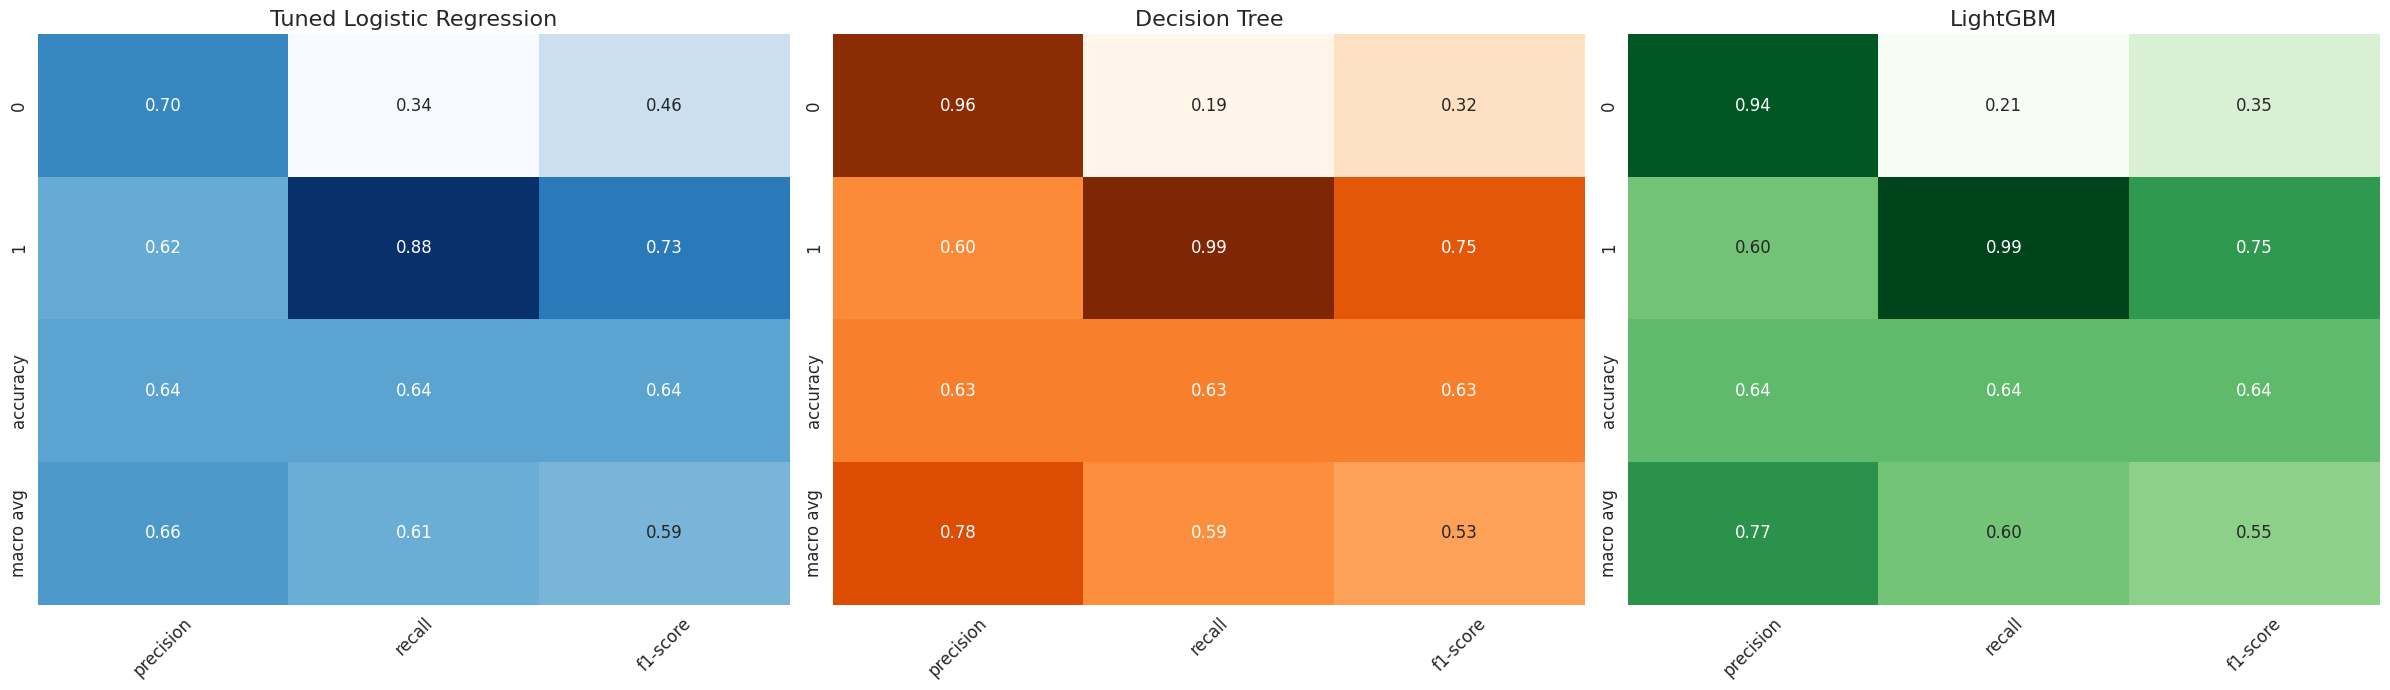

In [ ]:
# Classification Report


# Generate classification reports as DataFrames
report_log = pd.DataFrame(classification_report(y_test2, log_reg_pred2, output_dict=True)).T
report_dt = pd.DataFrame(classification_report(y_test2, y_pred_dt, output_dict=True)).T
report_lgbm = pd.DataFrame(classification_report(y_test2, final_pred_lgbm, output_dict=True)).T

# List of reports and titles
reports = [report_log, report_dt, report_lgbm]
titles = ["Tuned Logistic Regression", "Decision Tree", "LightGBM"]
cmaps = ["Blues", "Oranges", "Greens"]

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
for i, (report, title, cmap) in enumerate(zip(reports, titles, cmaps)):
    # Exclude 'accuracy' row and 'support' column for heatmap
    sns.heatmap(
        report.iloc[:-1, :-1],  # all rows except 'accuracy', all columns except 'support'
        annot=True, fmt=".2f", cmap=cmap, ax=axes[i], cbar=False,
        annot_kws={"size": 12}
    )
    axes[i].set_title(title, fontsize=16)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

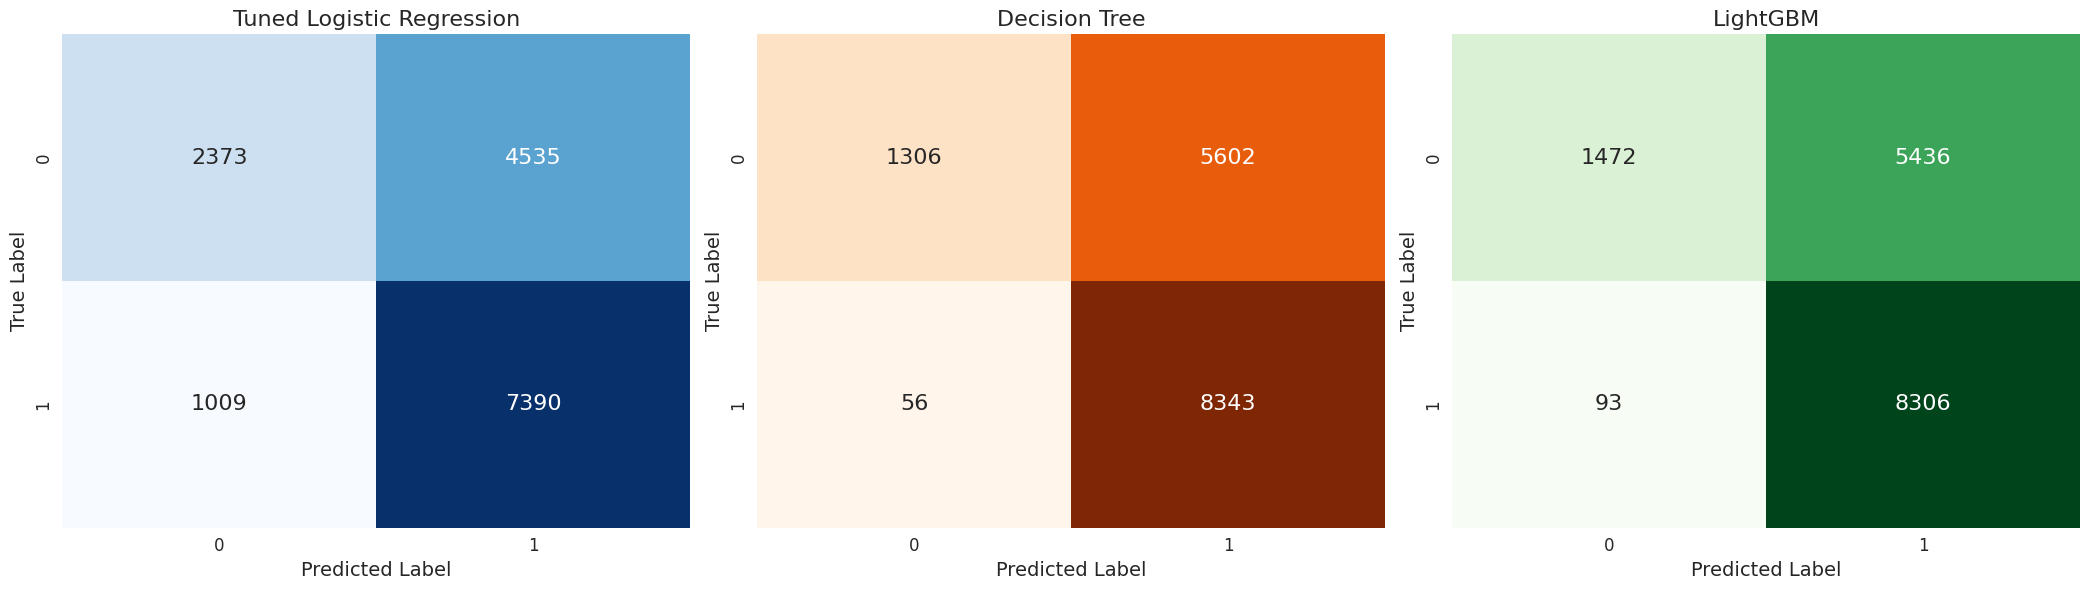

In [ ]:
# Confusion Matrices


# Compute confusion matrices
cm_log = confusion_matrix(y_test2, log_reg_pred2)
cm_dt = confusion_matrix(y_test2, y_pred_dt)
cm_lgbm = confusion_matrix(y_test2, final_pred_lgbm)

# List of confusion matrices and titles
cms = [cm_log, cm_dt, cm_lgbm]
titles = ["Tuned Logistic Regression", "Decision Tree", "LightGBM"]
cmaps = ["Blues", "Oranges", "Greens"]

# Optionally, set class labels (e.g., [0, 1] for binary)
class_labels = [0, 1]

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for i, (cm, title, cmap) in enumerate(zip(cms, titles, cmaps)):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        ax=axes[i],
        cbar=False,
        xticklabels=class_labels,
        yticklabels=class_labels,
        annot_kws={"size": 16}
    )
    axes[i].set_title(title, fontsize=16)
    axes[i].set_xlabel("Predicted Label", fontsize=14)
    axes[i].set_ylabel("True Label", fontsize=14)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()

# 050: Communicate Results 

Steps: 
1. Model Performance Metrics Summary
2. Feature Importance Plot of Best Model, LightGBM
3. Plot Tree of Best Model, LightGBM 

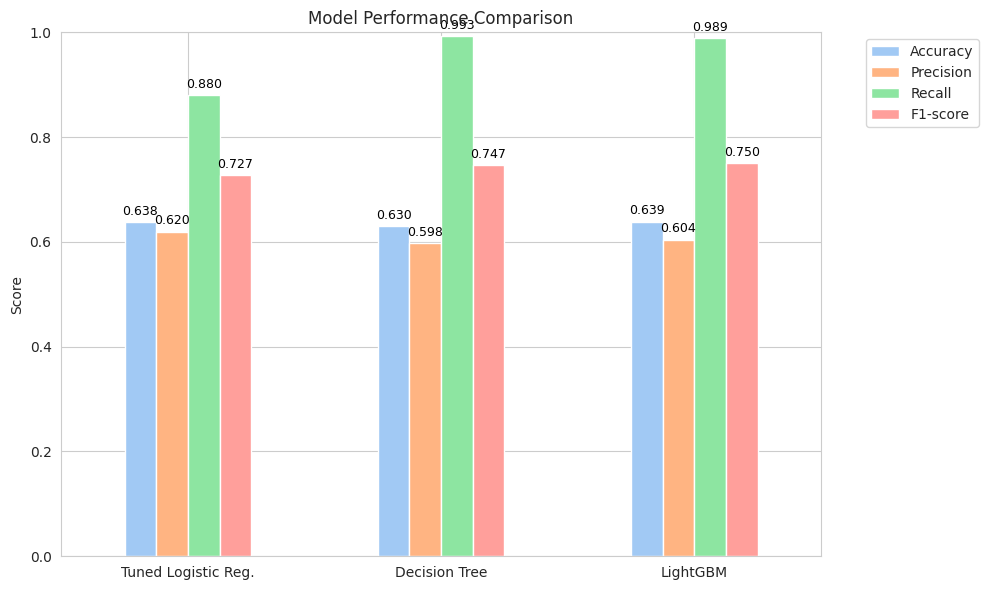

In [ ]:
# Model Performance Metrics Summary Table

model_metrics = {
    'Tuned Logistic Reg.': {
        'Accuracy': accuracy_score(y_test2, log_reg_pred2),
        'Precision': precision_score(y_test2, log_reg_pred2),
        'Recall': recall_score(y_test2, log_reg_pred2),
        'F1-score': f1_score(y_test2, log_reg_pred2)
    },
    'Decision Tree': {
        'Accuracy': accuracy_score(y_test2, y_pred_dt),
        'Precision': precision_score(y_test2, y_pred_dt),
        'Recall': recall_score(y_test2, y_pred_dt),
        'F1-score': f1_score(y_test2, y_pred_dt)
    },
    'LightGBM': {
        'Accuracy': accuracy_score(y_test2, final_pred_lgbm),
        'Precision': precision_score(y_test2, final_pred_lgbm),
        'Recall': recall_score(y_test2, final_pred_lgbm),
        'F1-score': f1_score(y_test2, final_pred_lgbm)
    }
}
# Create a DataFrame for easy comparison
summary_df = pd.DataFrame(model_metrics).T
# print(summary_df)

# Bar plot
ax = summary_df.plot(kind='bar', figsize=(10,6), rot=0)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)  # because metrics are between 0–1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate bars with values
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.3f}",   # format to 3 decimals
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=9, color='black', rotation=0, xytext=(0, 3),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

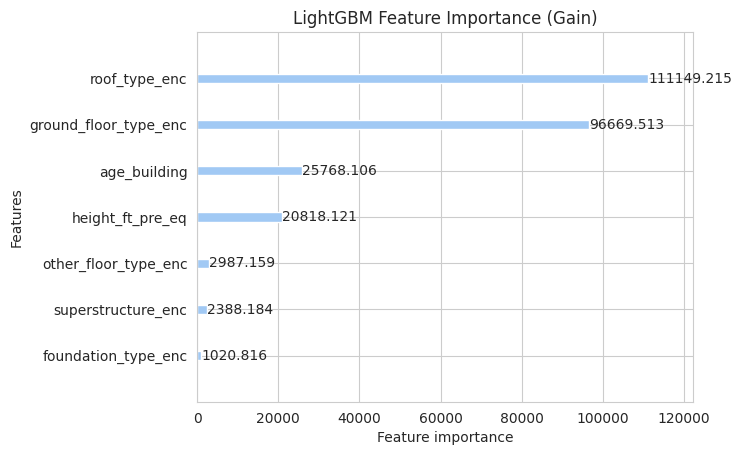

In [ ]:
# Feature Importance of the Best Model, LightGBM

lgb.plot_importance(final_lgbm, importance_type='gain', max_num_features=15)
plt.title("LightGBM Feature Importance (Gain)")
plt.show()

<Figure size 2500x1200 with 0 Axes>

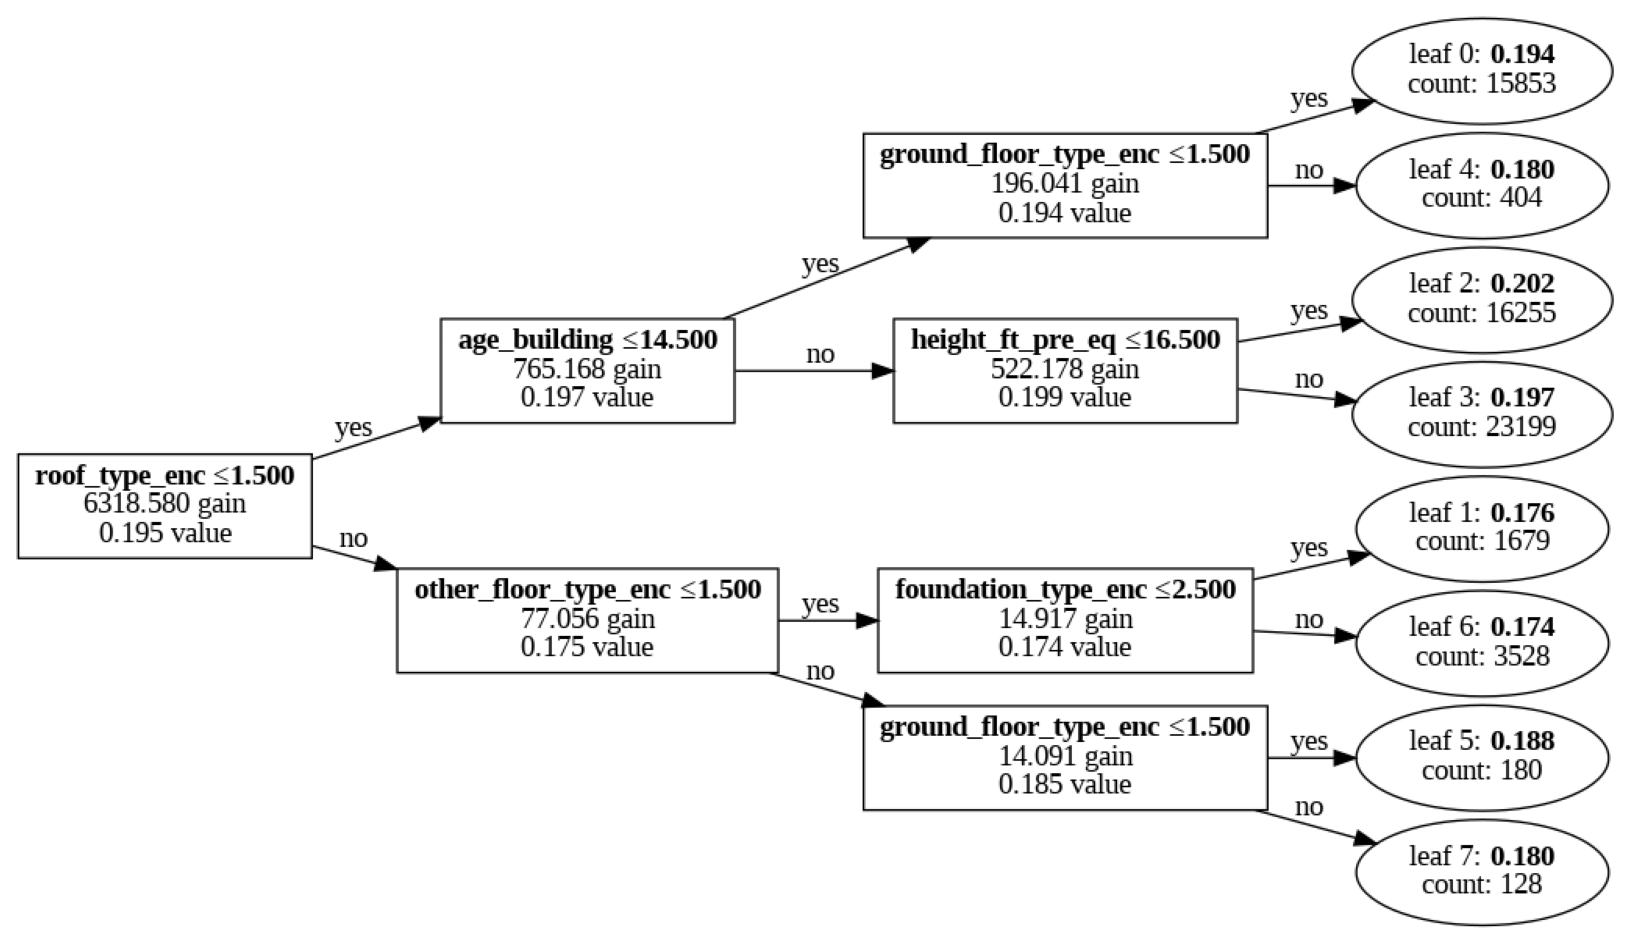

In [ ]:
# Plot Tree of the best model, LightGBM 


# Plot the first tree (tree_index=0)
plt.figure(figsize=(25, 12))
lgb.plot_tree(final_lgbm, tree_index=0, figsize=(25, 12), show_info=['split_gain', 'internal_value', 'leaf_count'])
plt.show()


# Save Trained Models

In [ ]:
# Save the LightGBM model to a text file, pkl file

import joblib

# as .txt with .booster_
final_lgbm.booster_.save_model('lightgbm_model.txt')

# as .pkl the model
# joblib.dump(final_lgbm, 'lightgbm_model.pkl')



# Interactive Dashboard


In [ ]:
# X_train2.info()

In [ ]:
# Mapping Encoded Values to Category Names

land_surface_map = {i: v for i, v in enumerate(label_encoders['land_surface_condition'].classes_)}
# Repeat for all categorical features
foundation_type_map = {i: v for i, v in enumerate(label_encoders['foundation_type'].classes_)}
roof_type_map = {i: v for i, v in enumerate(label_encoders['roof_type'].classes_)}
ground_floor_type_map = {i: v for i, v in enumerate(label_encoders['ground_floor_type'].classes_)}
other_floor_type_map = {i: v for i, v in enumerate(label_encoders['other_floor_type'].classes_)}
position_map = {i: v for i, v in enumerate(label_encoders['position'].classes_)}
plan_configuration_map = {i: v for i, v in enumerate(label_encoders['plan_configuration'].classes_)}
superstructure_map = {i: v for i, v in enumerate(label_encoders['superstructure'].classes_)}


In [ ]:
 # Interactive Dashboard Using X_train2

import ipywidgets as widgets
from ipywidgets import interact, IntSlider, Dropdown
import pandas as pd

# Prediction function using encoded values

def predict_damage(
    age_building, plinth_area_sq_ft, height_ft_pre_eq,
    land_surface_condition_enc, foundation_type_enc, roof_type_enc,
    ground_floor_type_enc, other_floor_type_enc, position_enc,
    plan_configuration_enc, superstructure_enc
):
    input_dict = {
        'age_building': [age_building],
        'plinth_area_sq_ft': [plinth_area_sq_ft],
        'height_ft_pre_eq': [height_ft_pre_eq],
        'land_surface_condition_enc': [land_surface_condition_enc],
        'foundation_type_enc': [foundation_type_enc],
        'roof_type_enc': [roof_type_enc],
        'ground_floor_type_enc': [ground_floor_type_enc],
        'other_floor_type_enc': [other_floor_type_enc],
        'position_enc': [position_enc],
        'plan_configuration_enc': [plan_configuration_enc],
        'superstructure_enc': [superstructure_enc]
    }
    X_input = pd.DataFrame(input_dict)
    pred = final_lgbm.predict(X_input)[0]
    proba = final_lgbm.predict_proba(X_input)[0][1]
    print(f"\nPredicted Severe Damage: {'YES' if pred == 1 else 'NO'}")
    print(f"Probability of Severe Damage: {proba:.2%}")

# Interactive controls using X_train2 and mapping dictionaries
interact(
    predict_damage,
    age_building=IntSlider(
        min=int(X_train2["age_building"].min()),
        max=int(X_train2["age_building"].max()),
        value=int(X_train2["age_building"].mean()),
    ),
    plinth_area_sq_ft=IntSlider(
        min=int(X_train2["plinth_area_sq_ft"].min()),
        max=int(X_train2["plinth_area_sq_ft"].max()),
        value=int(X_train2["plinth_area_sq_ft"].mean()),
    ),
    height_ft_pre_eq=IntSlider(
        min=int(X_train2["height_ft_pre_eq"].min()),
        max=int(X_train2["height_ft_pre_eq"].max()),
        value=int(X_train2["height_ft_pre_eq"].mean()),
    ),
    land_surface_condition_enc=Dropdown(
        options=[(v, i) for i, v in land_surface_map.items()],
        value=int(X_train2["land_surface_condition_enc"].mean()),
        description='Land Surface'
    ),
    foundation_type_enc=Dropdown(
        options=[(v, i) for i, v in foundation_type_map.items()],
        value=int(X_train2["foundation_type_enc"].mean()),
        description='Foundation'
    ),
    roof_type_enc=Dropdown(
        options=[(v, i) for i, v in roof_type_map.items()],
        value=int(X_train2["roof_type_enc"].mean()),
        description='Roof'
    ),
    ground_floor_type_enc=Dropdown(
        options=[(v, i) for i, v in ground_floor_type_map.items()],
        value=int(X_train2["ground_floor_type_enc"].mean()),
        description='Ground Floor'
    ),
    other_floor_type_enc=Dropdown(
        options=[(v, i) for i, v in other_floor_type_map.items()],
        value=int(X_train2["other_floor_type_enc"].mean()),
        description='Other Floor'
    ),
    position_enc=Dropdown(
        options=[(v, i) for i, v in position_map.items()],
        value=int(X_train2["position_enc"].mean()),
        description='Position'
    ),
    plan_configuration_enc=Dropdown(
        options=[(v, i) for i, v in plan_configuration_map.items()],
        value=int(X_train2["plan_configuration_enc"].mean()),
        description='Plan Config'
    ),
    superstructure_enc=Dropdown(
        options=[(v, i) for i, v in superstructure_map.items()],
        value=int(X_train2["superstructure_enc"].mean()),
        description='Superstructure'
    ),
);


interactive(children=(IntSlider(value=34, description='age_building', max=999), IntSlider(value=429, descripti…